# Задание 2: Работа с датасетами

## 2.1. Кастомный Dataset класс

In [79]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torchvision.transforms as tf

import pandas as pd
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

class CustomCSVDataset(Dataset):
    def __init__(self, config_path: str = None, **kwargs):
        if config_path:
            self.config = self._load_config(config_path)
        else:
            self.config = kwargs

        self.data = pd.read_csv(
            self.config['csv_param']['path'],
            sep=self.config['csv_param']['sep'],
            header=self.config['csv_param']['header'],
            names=self.config['csv_param']['names'],
            usecols=self.config['csv_param']['usecols'],
            skiprows=self.config['csv_param']['skiprows'],
            nrows=self.config['csv_param']['nrows'],
            index_col=self.config['csv_param']['index_col'],
            dtype=self.config['csv_param']['dtype'],
            na_values=self.config['csv_param']['na_values'],
            encoding=self.config['csv_param']['encoding'],
            converters=self.config['csv_param']['converters']
        )
        self.target_column: list = self.config['target_column']
        self.numeric_cols: list = self.config['numeric_cols']
        self.categorial_cols: list = self.config['categorial_cols']
        self.binary_cols: list = self.config['binary_cols']
        self.normalize_numeric: bool = self.config['normalize_numeric']
        self.scale_range: tuple = self.config['scale_range'] if self.config['scale_range'] else (-1, 1)
        self.transform: callable = self.config['transforms']

        if self.target_column:
            self.y = self.data[self.target_column].values
            self.data = self.data.drop(columns=self.target_column)
        else:
            raise ValueError("В графе 'target_column' пусто. Необходимо ввести столбец с целевой переменной")

        transformers = []

        if self.numeric_cols:
            if self.normalize_numeric:
                scaler = StandardScaler() 
            else:
                scaler = MinMaxScaler(feature_range=scale_range)  
            transformers.append(('num', scaler, self.numeric_cols))

        if self.categorial_cols:
            cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            transformers.append(('categorials', cat_encoder, self.categorial_cols))        

        if self.binary_cols:
            for col in self.binary_cols:
                self.data[col] = self.data[col].astype('float')

        self.preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder='passthrough'
        )

        self.X = self.preprocessor.fit_transform(self.data)

    def _load_config(self, path):
        with open(path, 'r', encoding='utf-8') as file:
            return json.load(file)
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.X)[0][index], torch.tensor(self.y).unsqueeze(0)[0][index]
        return torch.tensor(self.X, dtype=torch.float32)[index], torch.tensor(self.y, dtype=torch.float32).unsqueeze(0)[0][index]

### Тесты создания датасета

##### Создание с помощью файла

In [123]:
# Создание с помощью файла без трансформера (он не сериализуется, поэтому без него)
ds = CustomCSVDataset("_test/config.json")
print(f"Длина датасета: {len(ds)}\n")
print(f"Получение данных из датасета по индексу: {ds[0]}")

Длина датасета: 10000

Получение данных из датасета по индексу: (tensor([0.7752, 1.7042, 1.4562, 1.0000, 1.0000], dtype=torch.float64), tensor(91., dtype=torch.float64))


##### Создание с помощью словаря

In [82]:
config = {
    "csv_param": {
        "path": 'data/Student_Performance.csv',
        "sep": ',',
        "header": 'infer',
        "names": None,
        "usecols": None,
        "skiprows": None,
        "nrows": None,
        "index_col": None,
        "dtype": None,
        "na_values": None,
        "encoding": None,
        "converters": None
    },
    "target_column": 'Performance Index',
    "numeric_cols": ['Hours Studied', 'Previous Scores', 'Sleep Hours'],
    "categorial_cols": ['Sample Question Papers Practiced'],
    "binary_cols": ['Extracurricular Activities'],
    "normalize_numeric": True,
    "scale_range": None,
    "transforms": None, #v2.Compose([v2.ToTensor()]) # v2.Compose, если понадобится использовать множество трансформаций
}

ds = CustomCSVDataset(**config)
print(f"Длина датасета: {len(ds)}\n")
print(f"Получение данных из датасета по индексу: {ds[0]}")

Длина датасета: 10000

Получение данных из датасета по индексу: (tensor([0.7752, 1.7042, 1.4562, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000], dtype=torch.float64), tensor(91., dtype=torch.float64))


C:\miniconda\envs\ml\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## 2.2. Эксперименты с различными датасетами

#### Информация о датасетах, препроцессинг

** data/Student_Performance.csv - датасет для линейной регрессии, который показывает успеваемость учеников по определённым признакам. 
        
        - Ссылка на датасет: https://www.kaggle.com/datasets/whenamancodes/student-performance
    
** data/Loan_Data.csv - датасет для логистической регрессии, который показывает 
        
        - Ссылка на датасет: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

In [78]:
def preprocess_loan_dataset():
    df = pd.read_csv("data/Loan_Data.csv")
    
    df['person_gender'] = df['person_gender'].map({"male": 1, "female": 0})
    df.to_csv("data/Loan_Data.csv", index=False)

def preprocess_student_dataset():
    df = pd.read_csv("data/Student_Performance.csv")
    df['Extracurricular Activities'] = df['Extracurricular Activities'].map({"Yes": 1, "No": 0})
    df.to_csv("data/Student_Performance.csv", index=False)

preprocess_loan_dataset()
preprocess_student_dataset()

#### Обучение линейной регрессии

In [80]:
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import json

class LinearRegression(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        return self.linear(x)

# Конфигурация датасета для линейной регрессии
config_lin_reg = {
    "csv_param": {
        "path": 'data/Student_Performance.csv',
        "sep": ',',
        "header": 'infer',
        "names": None,
        "usecols": None,
        "skiprows": None,
        "nrows": None,
        "index_col": None,
        "dtype": None,
        "na_values": None,
        "encoding": None,
        "converters": None
    },
    "target_column": 'Performance Index',
    "numeric_cols": ['Hours Studied', 'Previous Scores', 'Sleep Hours'],
    "categorial_cols": ['Sample Question Papers Practiced'],
    "binary_cols": ['Extracurricular Activities'],
    "normalize_numeric": True,
    "scale_range": None,
    "transforms": None
}

dataset = CustomCSVDataset(**config_lin_reg)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

input_size = train_dataset[0][0].shape[0]
model = LinearRegression(input_size)

# Параметры регуляризации и ранней остановки
l1_lambda = 0.001  # Коэффициент для L1
l2_lambda = 0.01   # Коэффициент для L2 (через weight_decay в оптимизаторе)
patience = 8       # Для ранней остановки
best_val_loss = float('inf')
counter = 0 

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=l2_lambda)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

for epoch in range(100):
    model.train()
    train_loss = 0
    for batch_x, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = model(batch_x)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        
        # Добавление L1-регуляризации
        l1_reg = torch.tensor(0.)
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)
        loss += l1_lambda * l1_reg
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val.unsqueeze(1))
            val_loss += loss.item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict().copy()
        torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, 'models/lin_reg_task_2.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}, best val_loss: {best_val_loss:.4f}')
            break
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

C:\miniconda\envs\ml\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   0 | Train Loss: 3054.8654 | Val Loss: 2742.5236 | LR: 0.010000
Epoch  10 | Train Loss: 201.3730 | Val Loss: 169.9673 | LR: 0.010000
Epoch  20 | Train Loss: 28.8206 | Val Loss: 24.5753 | LR: 0.010000
Epoch  30 | Train Loss: 5.5780 | Val Loss: 4.9906 | LR: 0.010000
Epoch  40 | Train Loss: 4.7172 | Val Loss: 4.3872 | LR: 0.010000
Epoch  50 | Train Loss: 4.5227 | Val Loss: 4.2561 | LR: 0.010000
Epoch  60 | Train Loss: 4.4427 | Val Loss: 4.2216 | LR: 0.001000
Early stopping at epoch 61, best val_loss: 4.2124


#### Обучение логистической регрессии

Epoch [1/10], Train Loss: 0.2773, Val Loss: 0.2340
Epoch [2/10], Train Loss: 0.2279, Val Loss: 0.2257
Epoch [3/10], Train Loss: 0.2247, Val Loss: 0.2244
Epoch [4/10], Train Loss: 0.2237, Val Loss: 0.2230
Epoch [5/10], Train Loss: 0.2233, Val Loss: 0.2230
Epoch [6/10], Train Loss: 0.2232, Val Loss: 0.2235
Epoch [7/10], Train Loss: 0.2228, Val Loss: 0.2234
Epoch [8/10], Train Loss: 0.2229, Val Loss: 0.2259
Epoch [9/10], Train Loss: 0.2229, Val Loss: 0.2221
Epoch [10/10], Train Loss: 0.2231, Val Loss: 0.2240

Метрики лучшей модели:
precision: 0.7887
recall: 0.7433
f1_score: 0.7653
ROC-AUC: 0.9544


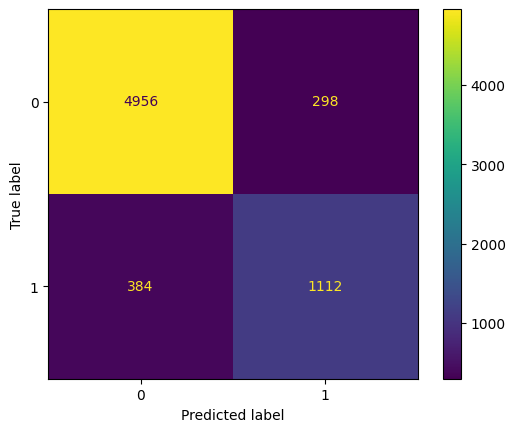

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

# Метрики с предыдущего задания
def precision(y_true: torch.Tensor, y_pred: torch.Tensor, is_binary: bool = True) -> float:
    if is_binary:
        true_pos = ((y_pred == 1) & (y_true == 1)).sum().float()
        false_pos = ((y_pred == 1) & (y_true == 0)).sum().float()
        return (true_pos / (true_pos + false_pos + 1e-10)).item()
        
    classes = torch.unique(y_true)
    precs = []
    for cls in classes:
        true_pos = ((y_pred == cls) & (y_true == cls)).sum().float()
        false_pos = ((y_pred == cls) & (y_true != cls)).sum().float()
        precision = true_pos / (true_pos + false_pos + 1e-10)
        precs.append(precision)
        
    return torch.mean(torch.tensor(precs)).item()

def recall(y_true: torch.Tensor, y_pred: torch.Tensor, is_binary: bool = True) -> float:
    if is_binary:
        true_pos = ((y_pred == 1) & (y_true == 1)).sum().float()
        false_neg = ((y_pred == 0) & (y_true == 1)).sum().float()
        return (true_pos / (true_pos + false_neg + 1e-10)).item()

    classes = torch.unique(y_true)
    recalls = []
    for cls in classes:
        true_pos = ((y_pred == cls) & (y_true == cls)).sum().float()
        false_neg = ((y_pred != cls) & (y_true == cls)).sum().float()
        recalls.append(true_pos / (true_pos + false_neg + 1e-10))

    return torch.mean(torch.tensor(recalls)).item()

def f1_score(y_true: torch.Tensor, y_pred: torch.Tensor, is_binary: bool = True) -> float:
    precision_value = precision(y_true, y_pred, is_binary=is_binary)
    recall_value = recall(y_true, y_pred, is_binary=is_binary)
    return (2 * precision_value * recall_value) / (precision_value + recall_value + 1e-10)

def _binary_roc_auc_score(y_true, y_scores):
    thresholds = torch.unique(y_scores).flip(0)
    tpr = []
    fpr = []
    
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).long()
        tp = ((y_true == 1) & (y_pred == 1)).sum().float()
        fp = ((y_true == 0) & (y_pred == 1)).sum().float()
        fn = ((y_true == 1) & (y_pred == 0)).sum().float()
        tn = ((y_true == 0) & (y_pred == 0)).sum().float()
        
        tpr.append((tp / (tp + fn + 1e-10)).item())
        fpr.append((fp / (fp + tn + 1e-10)).item())
    
    auc = 0.0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    return auc

def roc_auc_score(y_true: torch.Tensor, y_probs: torch.Tensor, is_binary: bool = True) -> float:
    if is_binary:
        if y_probs.dim() == 1:
            y_scores = y_probs
        else:
            y_scores = y_probs[:, 1] if y_probs.size(1) > 1 else y_probs[:, 0]
        return _binary_roc_auc_score(y_true, y_scores)
        
    classes = torch.unique(y_true)
    auc_scores = []
    
    for cls in classes:
        y_true_binary = (y_true == cls).long()
        y_scores = y_probs[:, cls]
        auc_scores.append(_binary_roc_auc_score(y_true_binary, y_scores))
    
    return torch.mean(torch.tensor(auc_scores)).item()

def calculate_metrics(y_true, y_pred, y_probs, is_binary):
    metrics = {}
    metrics['precision'] = precision(y_true, y_pred, is_binary)
    metrics['recall'] = recall(y_true, y_pred, is_binary)
    metrics['f1_score'] = f1_score(y_true, y_pred, is_binary)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_probs, is_binary)
    return metrics

# Конфигурация для логистической регрессии
config_log_reg = {
    "csv_param": {
        "path": 'data/Loan_Data.csv',
        "sep": ',',
        "header": 'infer',
        "names": None,
        "usecols": None,
        "skiprows": None,
        "nrows": None,
        "index_col": None,
        "dtype": None,
        "na_values": None,
        "encoding": None,
        "converters": None
    },
    "target_column": 'loan_status',
    "numeric_cols": [
        'person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 
        'credit_score'],
    "categorial_cols": ['person_education', 'person_home_ownership', 'loan_intent', 
                        'previous_loan_defaults_on_file'],
    "binary_cols": ['person_gender'],
    "normalize_numeric": True,
    "scale_range": None,
    "transforms": None
}

# Функция с задания 1
def plot_confusion_matrix(y_true, y_pred, class_names, filename):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.savefig(f'plots/{filename}.jpg')
    plt.show()

if __name__ == "__main__":
    dataset = CustomCSVDataset(config_path=None, **config_log_reg)
    
    num_classes = len(np.unique(dataset.y))
    is_binary = num_classes == 2
    
    # Разделение данных
    train_size = int(0.85 * len(dataset))  # 85% train
    val_size = len(dataset) - train_size   # 15% validation
    
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    model = LogisticRegression(dataset.X.shape[1], 1 if is_binary else num_classes)
    
    # Выбор функции потерь
    if is_binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
        
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Параметры для Early Stopping
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    best_metrics = None
    best_model_state = None
    best_preds = None
    best_labels = None
    class_names = np.unique(dataset.y)
    
    num_epochs = 10
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(inputs)
            
            if is_binary:
                labels = labels.float().unsqueeze(1)
            
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        model.eval()
        total_val_loss = 0
        epoch_preds = []
        epoch_labels = []
        epoch_probs = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                y_pred = model(inputs)
                
                if is_binary:
                    labels_for_loss = labels.float().unsqueeze(1)
                    loss = criterion(y_pred, labels_for_loss)
                    probs = torch.sigmoid(y_pred)
                    preds = (probs > 0.5).long().squeeze()
                else:
                    loss = criterion(y_pred, labels)
                    probs = torch.softmax(y_pred, dim=1)
                    _, preds = torch.max(y_pred, 1)
                
                total_val_loss += loss.item()
                epoch_preds.append(preds)
                epoch_labels.append(labels)
                epoch_probs.append(probs)
        
        avg_val_loss = total_val_loss / len(val_loader)
        epoch_preds = torch.cat(epoch_preds)
        epoch_labels = torch.cat(epoch_labels)
        epoch_probs = torch.cat(epoch_probs)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
            best_model_state = model.state_dict().copy()
            
            if is_binary:
                epoch_labels = epoch_labels.long()
            
            best_metrics = calculate_metrics(epoch_labels, epoch_preds, epoch_probs, is_binary)
            best_preds = epoch_preds
            best_labels = epoch_labels
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'metrics': best_metrics
            }, 'models/log_reg_task_2.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping сработал после {epoch+1} epochs. Best_val_loss: {best_val_loss}")
                break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    print("\nМетрики лучшей модели:")
    for name, value in best_metrics.items():
        print(f"{name}: {value:.4f}")
    
    plot_confusion_matrix(best_labels.numpy(), best_preds.numpy(), class_names, "log_reg_task_2")